<a href="https://www.kaggle.com/code/evelynartoria/pytorch-custom-dataset-for-cross-selling?scriptVersionId=188163912" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset

from sklearn.preprocessing import StandardScaler

In [3]:
train_dataset = pd.read_csv("/kaggle/input/playground-series-s4e7/train.csv")

In [4]:
print(len(train_dataset))
train_dataset.head(5)

11504798


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [5]:
train_dataset.drop(columns=["id"], inplace=True)

In [6]:
def check_data(dataset):
    for column in dataset.columns:
        if dataset[column].isnull().any():
            print(f"null value found in the column {column}")
check_data(dataset=train_dataset)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
7346608,Female,37,1,28.0,1,1-2 Year,Yes,2630.0,157.0,231,0
5630368,Male,44,1,28.0,0,1-2 Year,Yes,27398.0,26.0,52,1
5878136,Female,23,1,11.0,1,< 1 Year,No,2630.0,160.0,119,0
10613247,Male,77,1,28.0,0,> 2 Years,Yes,61597.0,26.0,197,0
8774753,Male,58,1,28.0,0,1-2 Year,Yes,29520.0,26.0,194,0


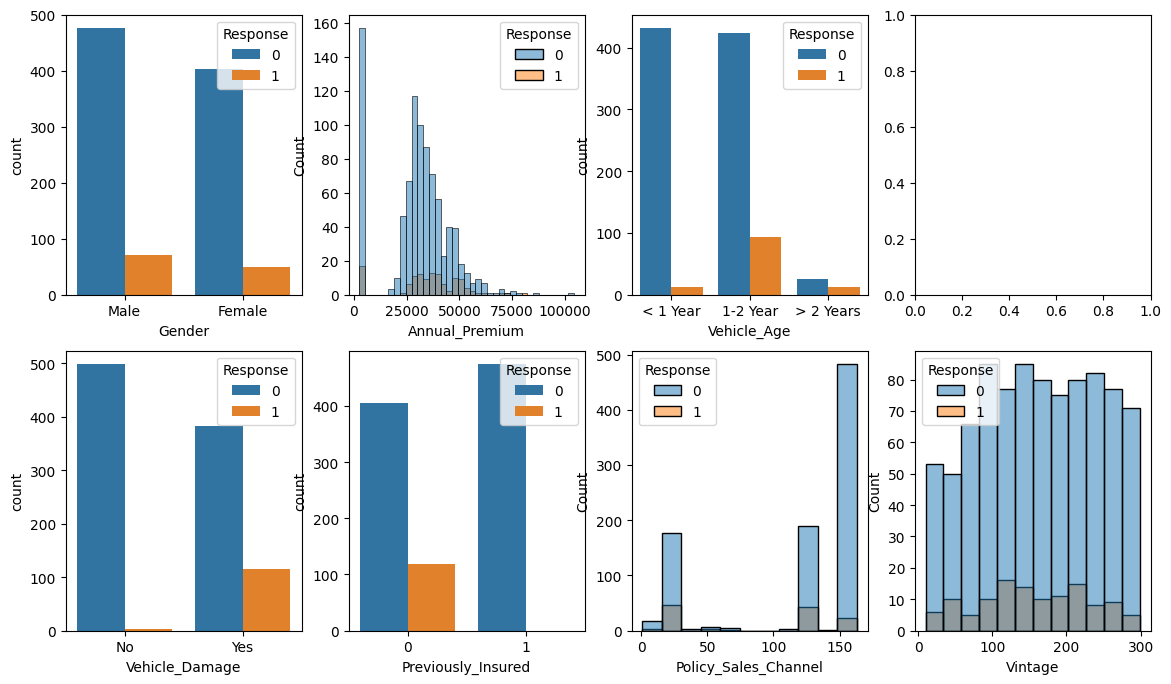

In [7]:
def plot_data(data):
    fig, axis = plt.subplots(2, 4, figsize=(14, 8))
    sns.countplot(data=data, x="Gender", hue="Response", ax=axis[0][0])
    sns.histplot(data=data, x="Annual_Premium", hue="Response", ax=axis[0][1])
    sns.countplot(data=data, x="Vehicle_Age", hue="Response", ax=axis[0][2])
    sns.countplot(data=data, x="Vehicle_Damage", hue="Response", ax=axis[1][0])
    sns.countplot(data=data, x="Previously_Insured", hue="Response", ax=axis[1][1]) 
    sns.histplot(data=data, x="Policy_Sales_Channel", hue="Response", ax=axis[1][2])
    sns.histplot(data=data, x="Vintage", hue="Response", ax=axis[1][3])

plot_data(data=train_dataset.sample(1000))
train_dataset.sample(5)

In [8]:
class CrossSellingDataset(Dataset):
    def __init__(self, dataset: pd.DataFrame, scaler: object = None):
        self.dataset = dataset

        gender_map = {c: v for v, c in enumerate(dataset["Gender"].unique())}
        vehicle_age_map = {c: v for v, c in enumerate(dataset["Vehicle_Age"].unique())}
        vehicle_damage_map = {c: v for v, c in enumerate(dataset["Vehicle_Damage"].unique())}
        dataset["Gender"] = dataset["Gender"].map(gender_map)
        dataset["Vehicle_Age"] = dataset["Vehicle_Age"].map(vehicle_age_map)
        dataset["Vehicle_Damage"] = dataset["Vehicle_Damage"].map(vehicle_damage_map)

        if scaler is not None:
            columns_to_scale = ["Age", "Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]
            dataset[columns_to_scale] = scaler.fit_transform(dataset[columns_to_scale])

        self.classes = [0, 1]


    def __len__(self):
        return len(dataset)

    def __getitem__(self, idx):
        data = self.dataset.iloc[idx].to_numpy()
        inputs = data[1:-1] # [1:-1] gets rid of the Response and the id
        label = data[-1]


        return (torch.tensor(inputs, dtype=torch.float32), torch.tensor(label, dtype=torch.long))
    
    @property
    def features(self):
        return self.dataset.columns
    
    @property
    def n_classes(sefl):
        return len(self.classes)

In [9]:
loaded_dataset = CrossSellingDataset(dataset=train_dataset, scaler=StandardScaler())
loaded_dataset[0]

(tensor([-1.1594,  1.0000,  0.6605,  0.0000,  0.0000,  0.0000,  2.1051,  0.2142,
          0.2889]),
 tensor(0))